Name: Nhat Minh Dang

ID: 222172836

My Sprint 2 task: Audio Detection for IceStorm:

## 1) Import libraries:

In [3]:
import os
import librosa
import soundfile as sf
import random
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

## 2) Scan and load audio inputs:

In [5]:
audio_dir = 'Tornado'
supported_formats = ['.mp3', '.wav']
audio_files = []

for file in os.listdir(audio_dir):
    if file.endswith(tuple(supported_formats)):
        audio_files.append(os.path.join(audio_dir, file))

print(f"Total audio files found: {len(audio_files)}")


Total audio files found: 6


## 3) Break audio data into small chunks:

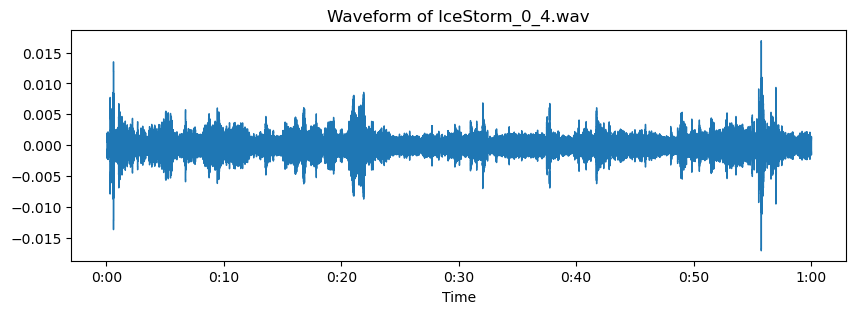

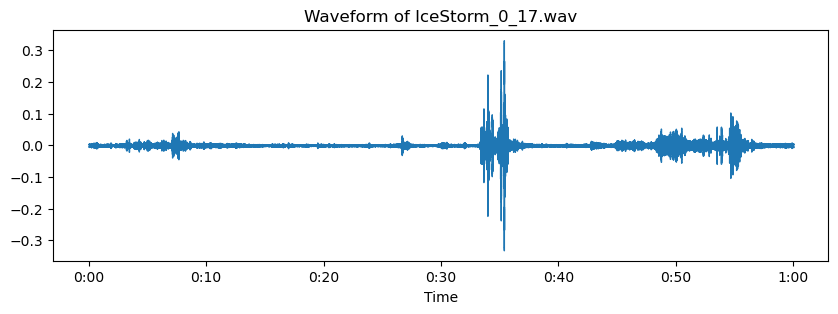

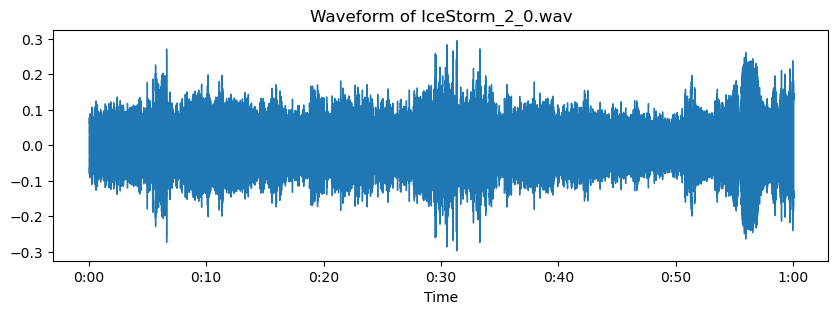

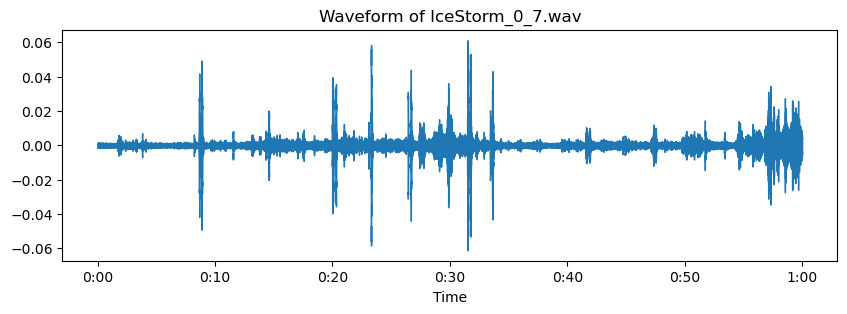

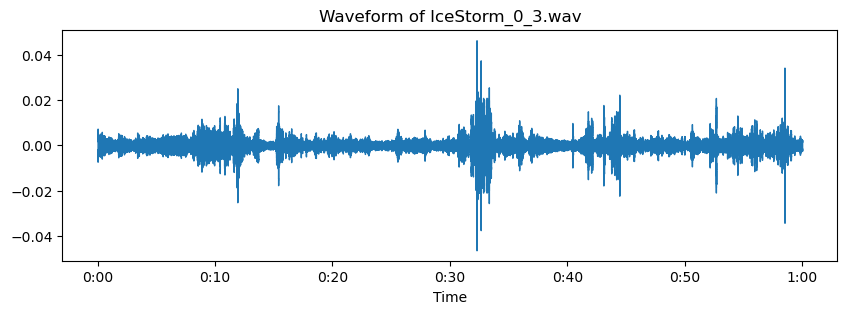

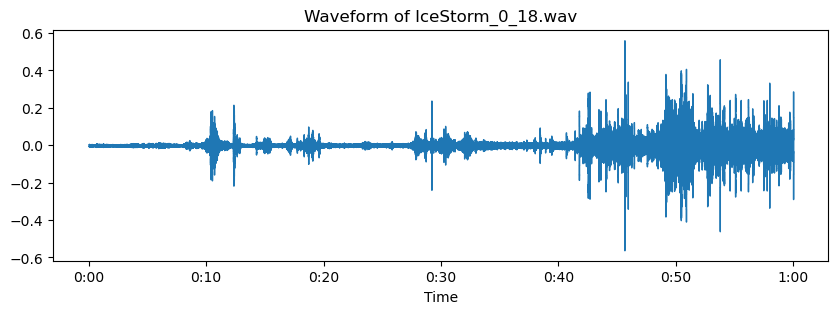

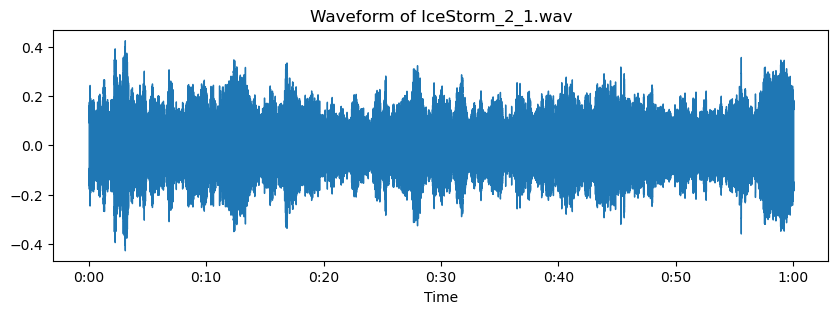

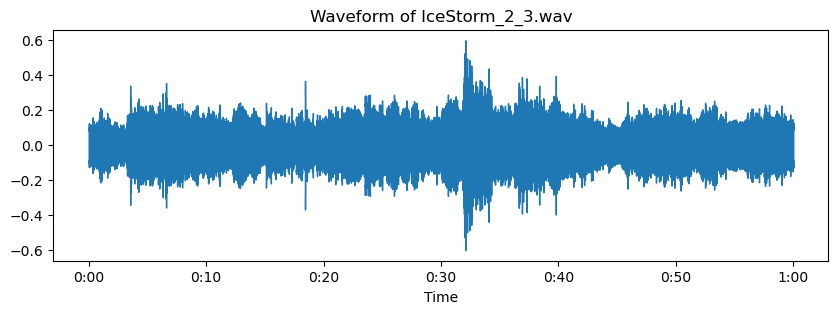

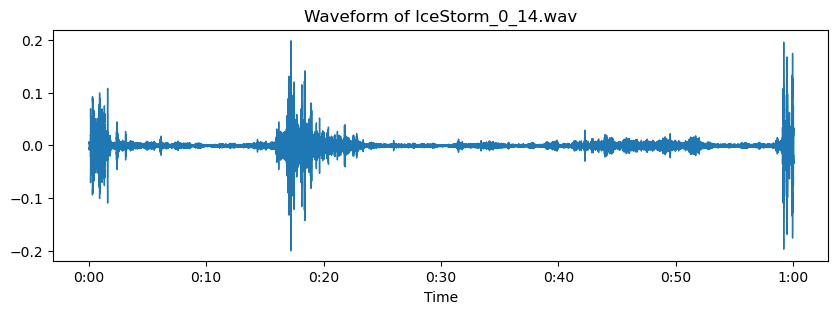

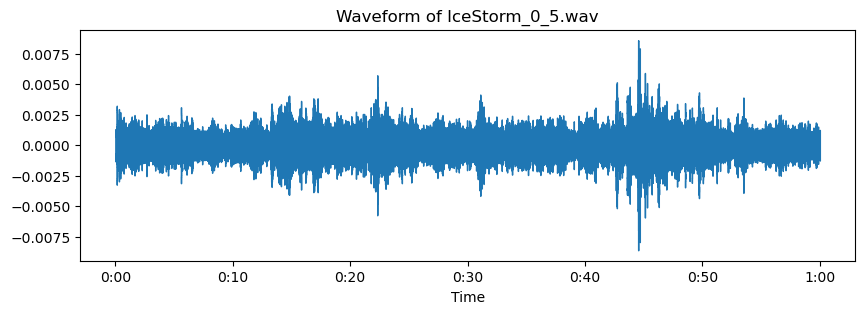

In [7]:
output_dir = 'TornadoData'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

chunk_duration = 60

for idx, file_path in enumerate(audio_files):
    audio, sr = librosa.load(file_path, sr=None)  
    total_duration = librosa.get_duration(y=audio, sr=sr)
    num_chunks = int(total_duration // chunk_duration) 

    for i in range(num_chunks):
        start = i * chunk_duration * sr
        end = start + chunk_duration * sr
        chunk = audio[int(start):int(end)]
        chunk_filename = f"IceStorm_{idx}_{i}.wav"
        sf.write(os.path.join(output_dir, chunk_filename), chunk, sr)

random_files = random.sample(os.listdir(output_dir), 10)

for file in random_files:
    audio, sr = librosa.load(os.path.join(output_dir, file), sr=None)
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveform of {file}')
    librosa.display.waveshow(audio, sr=sr)
    plt.show()


## 4) Perform Audio Augmentation:

In [9]:
def augment_audio(audio, sr):
    noise_amp = 0.005 * np.random.uniform() * np.amax(audio)
    audio_augmented = audio + noise_amp * np.random.normal(size=audio.shape)
    
    rate = np.random.uniform(0.8, 1.2)
    audio_augmented = librosa.effects.time_stretch(audio_augmented, rate=rate)
    
    n_steps = np.random.randint(-5, 6)  # Ensure n_steps includes 0
    audio_augmented = librosa.effects.pitch_shift(audio_augmented, sr=sr, n_steps=n_steps)
    
    return audio_augmented

def preprocess_audio(file_path, sr=22050, augment=False, target_shape=(128, 128)):
    audio, _ = librosa.load(file_path, sr=sr)

    audio = librosa.util.normalize(audio)
    
    if augment:
        audio = augment_audio(audio, sr)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_padded = np.zeros(target_shape)
    height, width = log_mel_spec.shape
    target_height, target_width = target_shape
    if width > target_width:
        log_mel_spec = log_mel_spec[:, :target_width]
        width = target_width
    if width < target_width:
        padding_width = target_width - width
        log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, padding_width)), mode='constant')
    mel_spec_padded[:log_mel_spec.shape[0], :log_mel_spec.shape[1]] = log_mel_spec
    
    return mel_spec_padded

target_shape = (128, 128)
output_dir = 'TornadoData'

processed_data = []
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    mel_spectrogram = preprocess_audio(file_path, target_shape=target_shape)
    processed_data.append(mel_spectrogram)
    
    mel_spectrogram_augmented = preprocess_audio(file_path, augment=True, target_shape=target_shape)
    processed_data.append(mel_spectrogram_augmented)

processed_data = np.array(processed_data)
print(f"Processed data shape: {processed_data.shape}")



Processed data shape: (50, 128, 128)


## 5) Train with Convolutional Neural Network:

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.5199 - loss: 14.5152 - val_accuracy: 0.5000 - val_loss: 36.1498
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5286 - loss: 32.8477 - val_accuracy: 0.5000 - val_loss: 33.7031
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5286 - loss: 31.4050 - val_accuracy: 0.5000 - val_loss: 10.1199
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5685 - loss: 8.4317 - val_accuracy: 0.5000 - val_loss: 5.5288
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3830 - loss: 6.4952 - val_accuracy: 0.5000 - val_loss: 0.9137
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4506 - loss: 0.9866 - val_accuracy: 0.5000 - val_loss: 0.7366
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4801 - loss: 0.7361 - val_accuracy: 0.5000 - val_loss: 1.1494
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4714 - loss: 1.0874 - val_accuracy: 0.5000 - val_loss: 

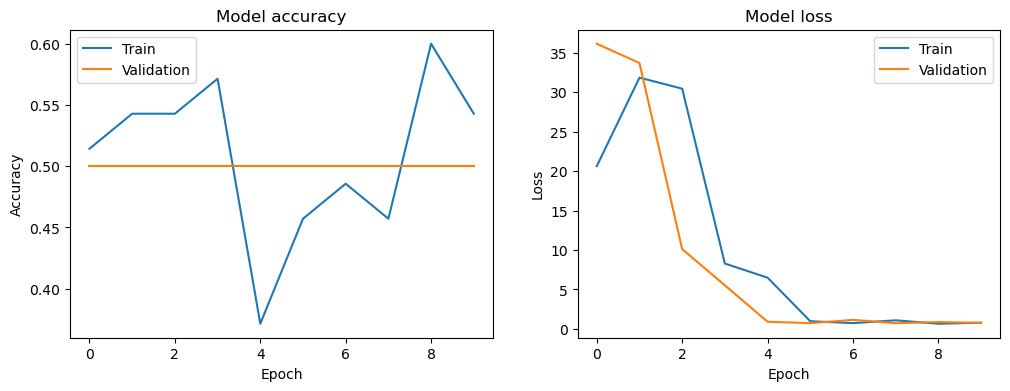

In [11]:
labels = np.random.randint(0, 2, size=(processed_data.shape[0],))  

X_train, X_temp, y_train, y_temp = train_test_split(processed_data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(128, 128, 1)),  
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


## 6) Additional Evaluation:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


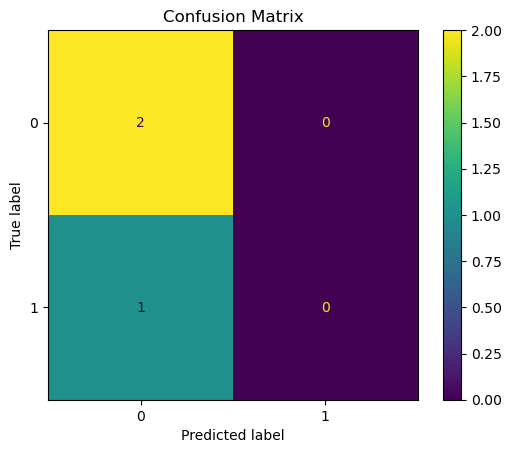

In [13]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix')
plt.show()


In [14]:
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.67      1.00      0.80         2
     Class 1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

